# Machine Learning pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  


## History
* Feb2022: Adding initial models with small dataset   
* March2022: Improved datasets representation
* April2022: Adds dataloader for clips and videos
* May2022: Tidies VGG2D and VGG3D   
* June2022: Tidies basicVGG model and adds heuristics for hyperarameters 
* Week1, July2022: Integreate modules in source path
* Week2, July2022: Implements Tromp2022Net DOI: https://doi.org/10.1016/S2589-7500(21)00235-17
* Week3, July2022: Adds LeNet, AlexNet and VGGNets, MobileNetV1, MobileNetV2
* Week4, July2022: Adds ShuffleNetV1, ShuffleNetV2, SqueezeNet_sources 0,1,2 and merge all to main!


## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* https://nestedsoftware.com/2019/09/09/pytorch-image-recognition-with-convolutional-networks-4k17.159805.html 
* https://ai.stackexchange.com/questions/5769/in-a-cnn-does-each-new-filter-have-different-weights-for-each-input-channel-or
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 
* Kerdegari H. et al. 2021 https://github.com/vital-ultrasound/lung/tree/main/multiclass_tensorflow
* https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
* https://github.com/shanglianlm0525/PyTorch-Networks



# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import io # io.StringIO(str(optimizer)
import sys
import argparse
import yaml
from pathlib import Path
import json
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm
import shutil

import numpy as np
import math
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, precision_recall_fscore_support
from datetime import datetime


from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.helpers.various import concatenating_YAML_via_tags, \
                                    plot_dataset_classes, \
                                    split_train_validate_sets
from source.helpers.learning_pipeline import get_class_distribution, \
                                            plot_from_dict, \
                                            creating_pair_of_clips, \
                                            pair_clips_labels, \
                                            animate_clips
from source.models.learning_misc import train_loop, \
                                        test_loop

from source.models.architectures import basicVGG, TrompNetV1, \
        LeNet5_source00, LeNet5_source01, LeNet5_source02, \
        AlexNet_source00, AlexNet_source01, AlexNet_source02, AlexNet_source03, \
        MobileNetV1, MobileNetV2, \
        SqueezeNet_source0, SqueezeNet_source1, SqueezeNet_source2
        #ShuffleNetV1, ShuffleNetV2 (require 3 channels of input images)

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_REPO_MODEL_PATH = HOME_PATH +'/' + REPOSITORY_PATH + '/data/models'
CONFIG_FILES_PATH= REPOSITORY_PATH + '/scripts/config_files/users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)
PATH_for_temporal_files = os.path.join(HOME_PATH, 'datasets/vital-us/echocardiography/temporal-files')

## Setting TRAINING_CURVES_PATH
#CURRENT_PATH=os.path.abspath(os.getcwd())
RESULTS_PATH='scripts/learning-pipeline/results'
TRAINING_CURVES_PATH = os.path.join(FULL_REPO_PATH, RESULTS_PATH)

## Setting FULL_PATH_FOR_YML_FILE
yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )
print(f'FULL_REPO_MODEL_PATH: {FULL_REPO_MODEL_PATH}' )
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )



PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files/users_paths_files/config_users_paths_files_username_mx19.yml
FULL_REPO_MODEL_PATH: /home/mx19/repositories/echocardiography/data/models
TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results


## 2. Generate list text files for train and validate datasets

Edit config_users_paths_files_username_$USER.yml at '../config_files/users_paths_files/config_users_paths_files_username_template.yml' with the right paths and percentage of `ntraining`:  
```
#ECHODATASET_PATH = config['echodataset_path'] # Default
ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-GOOD'
TRAINING_SPLITTING = 0.8 #config['ntraining'] #Default
randomise_file_list: False
```

## 2. Setting variables and loading datasets using pytorch dataloader

In [2]:
START_TIME_OF_THE_NOTEBOOK = time.time()
print(f'Starting time of the notebook {START_TIME_OF_THE_NOTEBOOK}')


##############################
##### Setting up device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #or "cuda:NN" can also be used e.g., "cuda:0"
print(f'Device: {DEVICE}')

# TRAIN_VERSION='train00'
# TRAIN_VERSION='train01'
TRAIN_VERSION='train02'


### Trump et al. 2022 
##"We trained the models on 55487 images from 1145 individual echocardiograms (appendix pp 2–3)." 
##Appendix pp 2–3.
##AC4: TRAINING: total videos 740 total frames 9615; T
##      TESTING: total videos:64 total frames 1218                


##############################
## Setting ECHODATASET_PATH; 
#ECHODATASET_PATH = config['echodataset_path'] # Default

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 720,
    #"Test Dataset Size": 320,
    #"Validation Dataset Size": 280,

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 1280,
    #"Test Dataset Size": 560,
    #"Validation Dataset Size": 440,

# ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-20-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 2240,
    #"Test Dataset Size": 960,
    #"Validation Dataset Size": 720,

ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects'
    #"BATCH_SIZE_OF_CLIPS": 20,
    #"FRAMES_PER_CLIP": 1,
    #"Train Dataset Size": 3620,
    #"Test Dataset Size": 1540,
    #"Validation Dataset Size": 880,

#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-in-verification40-49'


TRAINING_SPLITTING = 0.70 #config['ntraining'] #Default
TEST_FRACTION = 0.15
VAL_FRACTION = 1-TRAINING_SPLITTING-TEST_FRACTION
print(f'train_set_size  {TRAINING_SPLITTING}, test_set_size {TEST_FRACTION}, val_test_size {VAL_FRACTION}')

FLAG_RANDOMISE_DATA=True #config['randomise_file_list'] #Default

split_train_validate_sets(  
                        ECHODATASET_PATH, #config['echodataset_path']
                        config['data_list_output_path'], 
                        TRAINING_SPLITTING,
                        TEST_FRACTION,
                        FLAG_RANDOMISE_DATA
                        )

# PRETRANSFORM_IM_SIZE = [64, 64] #[650, 690] original pixel size for VenueGO
PRETRANSFORM_IM_SIZE = [128, 128] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [256, 256] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [512, 512] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = config['pretransform_im_size'] ##DEFAULT

### >> CHANGE DENSE LAYER FEATURES IN VGG3D
### >> `self.fc0 = nn.Linear(in_features=4194304, out_features=500) #128x128`

##############################
##### Experiments for Basic HYPERPARAMETER Heuristics 

#### TESTS
NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 20; 
#LEARNING_RATE= 0.00005; 


#################  LEARNING_RATE 
### EXPERIMENT 01,02,03,04
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 1; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.0000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 20; LEARNING_RATE= 0.00000005; 

#################  BATCH_SIZE_OF_CLIPS with LEARNING_RATE= 0.000005 as it is the best peformance of prevous LRs 
### EXPERIMENT 04,06,07,08
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 2; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 5; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10; BATCH_SIZE_OF_CLIPS = 15; LEARNING_RATE= 0.000005; 

#################  NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP with LEARNING_RATE= 0.000005 and BATCH_SIZE_OF_CLIPS=10
### EXPERIMENT 09,10,11,12
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 2; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 7; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 13; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 20; BATCH_SIZE_OF_CLIPS = 10; LEARNING_RATE= 0.000005; 

##TOADD
### * NUMBER_OF_FRAMES_AND PARTICPANTS
### * OPTIMISERS 

# LEARNING_RATE =Trial and Error with diffent values  0.00005; 0.0005; 0.005 and 0.000001; 0.00001; 0.0001; 0.001  


MAX_EPOCHS = 500 #Alternatvely, make use of: config['max_epochs']


##############################
##### Setting up animation
interval_between_frames_in_milliseconds=33.3 ## 1/30=0.033333
frame_per_seconds_for_animated_frames=30



#SUBJECT_ID = '073'
#print(SUBJECT_ID)

### CUDA out of memory 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10
#PRETRANSFORM_IM_SIZE = [128, 128] 
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.05 GiB free; 8.53 GiB reserved in total by PyTorch)
## REBOOT MACHINE
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.13 GiB free; 8.53 GiB reserved in total by PyTorch)



##############################
## Setting labels
label_id = ('BKGR', '4CV')



Starting time of the notebook 1659654789.1266103
Device: cuda
train_set_size  0.7, test_set_size 0.15, val_test_size 0.15000000000000005
---------------------------------------------
  FILENAMES_len=80
======= video_filenames: ('/01NVb-003-051/T2/01NVb-003-051-2 echo.mp4', '/01NVb-003-045/T2/01NVB-003-045-2 echo.mp4', '/01NVb-003-056/T2/01NVb-003-056-2 echo.mp4', '/01NVb-003-045/T3/01NVb-003-045-3 echo.mp4', '/01NVb-003-073/T1/01NVb-003-073-1 echo.mp4', '/01NVb-003-044/T3/01NVb-003-044-3 echo.mp4', '/01NVb-003-064/T1/01NVb-003-064-1 echo.mp4', '/01NVb-003-050/T2/01NVb-003-050-2 echo.mp4', '/01NVb-003-076/T2/01NVb-003-076-2 echo.mp4', '/01NVb-003-071/T1/01NVb-003-071-1 echo.mp4', '/01NVb-003-046/T1/01NVb-003-046-1 echo.mp4', '/01NVb-003-078/T2/01NVb-003-078-2 echo.mp4', '/01NVb-003-058/T3/01NVb-003-058-3 echo.mp4', '/01NVb-003-074/T1/01NVb-003-074-1 echo.mp4', '/01NVb-003-057/T2/01NVb-003-057-2 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-2 echo.mp4', '/01NVb-003-061/T3/01NVb-003-061-3 e

In [3]:
# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=PRETRANSFORM_IM_SIZE),
        transforms.ToTensor(),
    ])
else:
    pretransform = None
    
    #config['use_train_augmentation']#Default
    
    
# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


train_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=train_transform, #None,#transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )

test_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_test'],
    participant_path_json_list=config['participant_path_json_list_test'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=test_transform,
    use_tmp_storage=config['use_tmp_storage']
    )

val_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=val_transform,
    use_tmp_storage=config['use_tmp_storage']
    )



  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects//01NVb-003-051/T2/01NVb-003-051-2 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.036915077465064 nframes=20787 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects//01NVb-003-045/T2/01NVB-003-045-2 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.97203398407009 nframes=14956 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects//01NVb-003-056/T2/01NVb-003-056-2 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.97002997002997 nframes=56340 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects//01NVb-003-045/T3/01NVb-003-045-3 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.971736011469602 nframes=17568 
  
 

  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects//01NVb-003-069/T1/01NVb-003-069-1 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.97138118869408 nframes=22181 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects//01NVb-003-063/T2/01NVb-003-063-2 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.970910949187793 nframes=34020 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects//01NVb-003-054/T3/01NVb-003-054-3 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.971997023716636 nframes=15237 
  
  
  
  
  
  VIDEO_FEATURES
    video_name=/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects//01NVb-003-079/T1/01NVb-003-079-1 echo.mp4
    Frame_height=1080, frame_width=1920 fps=29.97203613041353 nframes=14940 
  
 

## 3. Plotting Class Distribution (creates temp clips and it takes few minutes)

[INFO] [EchoClassesDataset.__getitem__()] - computing clips and saving to temporary folder /home/mx19/datasets/vital-us/echocardiography/temporal-files/echovideodatafiles_FRAMESPERCLIP1_PIXELSIZE_128W128H


/home/mx19/anaconda3/envs/rt-ai-echo-VE/lib/python3.8/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /tmp/pip-req-build-pma2oi4d/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


class_distribution(train_dataset): {'BKGR': 111, '4CV': 111}
class_distribution(test_dataset): {'BKGR': 18, '4CV': 18}
class_distribution(val_dataset): {'BKGR': 22, '4CV': 22}
Number of frames for training datasets 222
Number of frames for testing datasets 36
Number of frames for Validation datasets 44


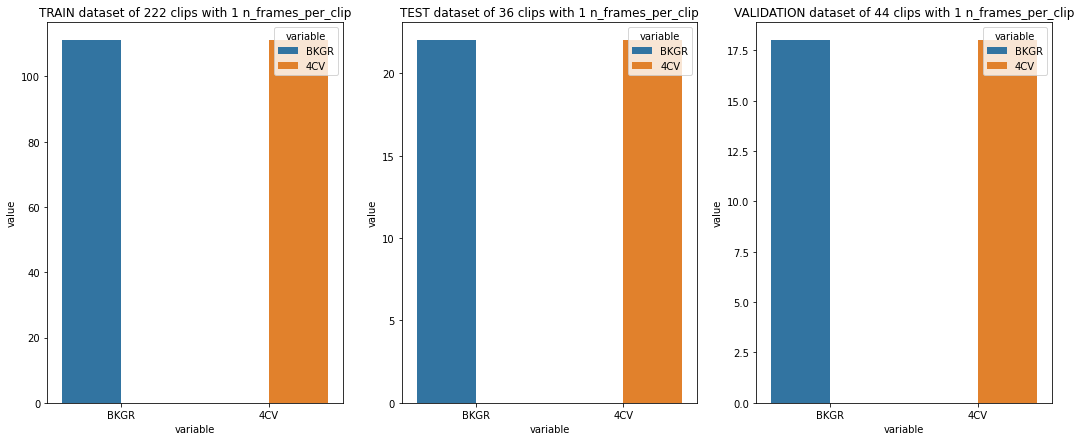

In [4]:
train_set_class_dict = get_class_distribution(train_dataset,label_id)
test_set_class_dict = get_class_distribution(test_dataset,label_id)
val_set_class_dict = get_class_distribution(val_dataset,label_id)


print(f'class_distribution(train_dataset): {train_set_class_dict}')
print(f'class_distribution(test_dataset): {test_set_class_dict}')
print(f'class_distribution(val_dataset): {val_set_class_dict}' )
    
#number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip']    
print(f'Number of frames for training datasets {len(train_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for testing datasets {len(test_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for Validation datasets {len(val_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')

plot_title_train_label= f'TRAIN dataset of {len(train_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(val_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(train_set_class_dict, plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(val_set_class_dict, plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(test_set_class_dict, plot_title=plot_title_val_label, ax=axes[2])
plt.show()



## 4. Animating frames of one clip of the dataloader

In [5]:
print(f'-----------------[val_dataset]-----------------')
clips=creating_pair_of_clips(val_dataset, label_id)
pair_clips_and_labels = pair_clips_labels(clips)

print(f'-----------------[test_dataset]-----------------')
clips=creating_pair_of_clips(test_dataset, label_id)
pair_clips_and_labels = pair_clips_labels(clips)

print(f'-----------------[train_dataset]-----------------')
clips=creating_pair_of_clips(train_dataset, label_id)
pair_clips_and_labels = pair_clips_labels(clips)


-----------------[val_dataset]-----------------
 CLIP:00 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 45
 CLIP:01 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 9
 CLIP:02 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 21
 CLIP:03 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 139
 CLIP:04 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 39 from clip_frame_clip_idx 1
 CLIP:05 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 116
 CLIP:06 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 10
 CLIP:07 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 55
 CLIP:08 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 116
 CLIP:09 of BKGR label for torch.S

 CLIP:60 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 10
 CLIP:61 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 121
 CLIP:62 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 139
 CLIP:63 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 115
 CLIP:64 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 5
 CLIP:65 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 20
 CLIP:66 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 133
 CLIP:67 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 17
 CLIP:68 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 141
 CLIP:69 of BKGR label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 150 from

 CLIP:178 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 123 from clip_frame_clip_idx 27
 CLIP:179 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 112 from clip_frame_clip_idx 74
 CLIP:180 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 94 from clip_frame_clip_idx 23
 CLIP:181 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 97 from clip_frame_clip_idx 30
 CLIP:182 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 90 from clip_frame_clip_idx 29
 CLIP:183 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 86 from clip_frame_clip_idx 12
 CLIP:184 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 79 from clip_frame_clip_idx 63
 CLIP:185 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 115 from clip_frame_clip_idx 83
 CLIP:186 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 96 from clip_frame_clip_idx 14
 CLIP:187 of 4CV label for torch.Size([1, 1, 128, 128]) TOTAL_FRAMES: 102 from clip_fram

<Figure size 432x288 with 0 Axes>

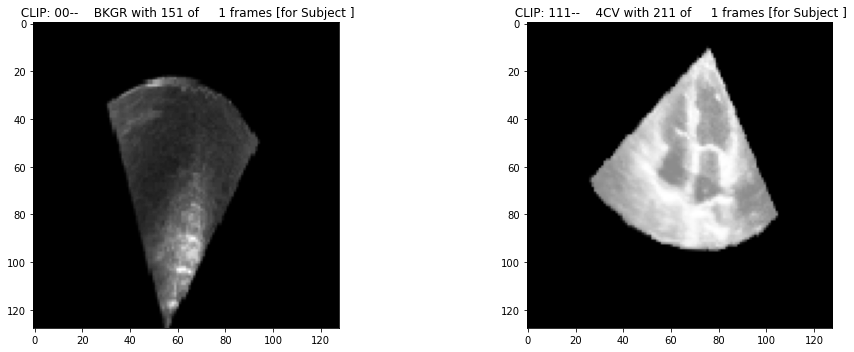

In [6]:
#average_HR =
#fps = 30
# 60 # beats per minute
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

PAIR_OF_CLIPS = pair_clips_and_labels[0]

animated_frames=animate_clips(PAIR_OF_CLIPS, label_id, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP,
                  interval_between_frames_in_milliseconds)
HTML(animated_frames.to_jshtml())      


# ##SAVE ANIMATIONS
# for idx in range(0,len(pair_clips_labels)):
#     PAIR_OF_CLIPS = pair_clips_labels[idx]
#     print( f' pair_clips_labels {str(PAIR_OF_CLIPS[2])} {str(PAIR_OF_CLIPS[6])}')
    

## 5. Displayting frames in the dataloader

In [7]:
print(f'====================================================')
print(f'train_dataset.__len__() = {train_dataset.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True,
    num_workers=0)


print(f'====================================================')
print(f'len(train_dataloader): {len(train_dataloader)} BATCHES of BATCH_SIZE_OF_CLIPS {BATCH_SIZE_OF_CLIPS}')
for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'  ====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'    BATCH_OF_CLIPS_INDEX : {clip_batch_idx} / {len(train_dataloader) - 1}')
    print(f'    sample_batched_labels.size(): {  sample_batched_labels.size()  }')
    print(f'    sample_batched_labels.squeeze().size(): {  sample_batched_labels.squeeze().size()  }')
    print(f'    sample_batched_images.size(): {sample_batched_images.size()}')

    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'        BATCH_SIZE_IDX {BATCH_SIZE_IDX} ')
        print(f'          label: {label}')
        sample_batched_idx_image = sample_batched_images[BATCH_SIZE_IDX,...]
        print(f'          Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )

        grid = utils.make_grid(sample_batched_idx_image)
        print(f'          Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()


print(f'====================================================')
print(f' test_dataset.__len__() = {test_dataset.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f'====================================================')
print(f' validation_dataset.__len__() = {val_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

train_dataset.__len__() = 222
len(train_dataloader): 12 BATCHES of BATCH_SIZE_OF_CLIPS 20
    BATCH_OF_CLIPS_INDEX : 0 / 11
    sample_batched_labels.size(): torch.Size([20])
    sample_batched_labels.squeeze().size(): torch.Size([20])
    sample_batched_images.size(): torch.Size([20, 1, 1, 128, 128])
        BATCH_SIZE_IDX 0 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 1 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 2 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 3 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 4 
          label: 1


    BATCH_OF_CLIPS_INDEX : 4 / 11
    sample_batched_labels.size(): torch.Size([20])
    sample_batched_labels.squeeze().size(): torch.Size([20])
    sample_batched_images.size(): torch.Size([20, 1, 1, 128, 128])
        BATCH_SIZE_IDX 0 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 1 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 2 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 3 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 4 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid siz

    BATCH_OF_CLIPS_INDEX : 9 / 11
    sample_batched_labels.size(): torch.Size([20])
    sample_batched_labels.squeeze().size(): torch.Size([20])
    sample_batched_images.size(): torch.Size([20, 1, 1, 128, 128])
        BATCH_SIZE_IDX 0 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 1 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 2 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 3 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid size torch.Size([3, 128, 128])
        BATCH_SIZE_IDX 4 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 1, 128, 128])
          Grid siz

## 7. Define networks
See `$HOMErepositories/echocardiography/source/models/arquitectures.py` to amend or implement other Neural Network Arquitectures!

In [8]:
# I leave this cell as it is useful for user(s) to prototype other newtorks



## 8. Sanity checks for the model and dataloaders

In [9]:
##################################################################
##################################################################
##################################################################

##################################################################
##################################################################
##################################################################
##### Tensor Shape
#tensor_shape_size = [BATCH_SIZE_OF_CLIPS, config['number_of_frames_per_segment_in_a_clip'], 1, 128, 128]
#model = basicVGGNet(tensor_shape_size)

#n_frames_per_clip 
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #torch.Size([BATCH_SIZE_OF_CLIPS, CLASS_NUMBER])
#model = TrompNet2022(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)

#model = TrompNetV1(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#Total params: 402,284

# model=LeNet5_source00()#Total params: 6,350,946
# model=LeNet5_source01()#Total params: 1,627,790
# model=LeNet5_source02()#Total params: 1,741,026

# model = AlexNet_source00()#Total params: 56,996,546
# model = AlexNet_source01()#Total params: 24,714,626 
# model = AlexNet_source02()#Total params: 28,841,314
# model = AlexNet_source03(num_classes=2, in_channels=1)#Total params: 56,996,546 

# model=MobileNetV1(ch_in=1, n_classes=2)#Total params: 3,208,450
model=MobileNetV2(ch_in=1, n_classes=2)#Total params: 2,225,858


#model=SqueezeNet_source0(num_classes=2, in_channels=1) #Total params: 733,580
# model=SqueezeNet_source1(num_classes=2, in_channels=1) #Total params: 729,154
# model=SqueezeNet_source2(channels=1, class_count=2) #Total params: 722,370
    
    
##TRIALS        
# model=ShuffleNetV1_G3()##RuntimeError: expected to have 3 channels
# model = shufflenetv2()##RuntimeError: expected to have 3 channels
# https://github.com/ntoussaint/fetalnav/blob/master/fetalnav/models/vgg.py
# model = VGG(cfg=VGGlayers, batch_norm=batch_norm, in_channels=1, num_classes=2)      
# model = ResNet(RNblock, RNlayers, num_classes=2, in_channels=1) #Total params: 21,279,426


model.to(DEVICE) # Place model on GPU

print(model) 
print(summary(model))
#print(str(summary(model, (1, 32, 32), depth=1)))

### Sanity check
#print(len(train_dataloader)) #6 BATCHES of 10=BATCH_SIZE_OF_CLIPS
sample_batched = next(iter(train_dataloader))
#print(sample_batched[0].shape) #torch.Size([10, 60, 1, 128, 128])
#print(sample_batched[1])#tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1])
#print(sample_batched[2]) #tensor([47, 42,  0, 51, 49, 75, 67, 67, 62, 84])
#print(sample_batched[3]) #tensor([105, 102,  43, 106,  94, 161, 151, 183, 150, 151])

clip_batch = sample_batched[0]
#print(f'clip_batch.size() {clip_batch.size()}') ##torch.Size([4, 60, 1, 128, 128])
#                                                ##[batch_size, channels, depth, height, width]

# # frames = image.to(device)
print(f'Shape of vector: {model(clip_batch).shape}' ) #torch.Size([4, 2])
print(f'Type of variable  {type(model(clip_batch))}')  #torch.Size([4, 2]) #<class 'torch.Tensor'>

# #https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
del sample_batched
torch.cuda.empty_cache()

MobileNetV2(
  (stem_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layers): Sequential(
    (0): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

Shape of vector: torch.Size([20, 2])
Type of variable  <class 'torch.Tensor'>


## 8. Define Optimizer and setting up of other hyperameters
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Set the number of clips per batch

In [10]:
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
#model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #torch.Size([BATCH_SIZE_OF_CLIPS, CLASS_NUMBER])


# ############################
# #### TrompNetV1 #Total params: 402,284
# model = TrompNetV1(PRETRANSFORM_IM_SIZE, BATCH_SIZE_OF_CLIPS, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
# # gamma=0.00005
# # #gamma=0.00001
# # criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(model.parameters(), lr=gamma)
# # model.to(DEVICE) # Place model on GPU
# # LEARNING_RATE = gamma

# gamma=0.001
# rho=.9 
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho) 
# model.to(DEVICE) # Place model on GPU
# LEARNING_RATE = gamma


# ############################
# #### LeNet5_sourceNN
# # model=LeNet5_source00() #Total params: 6,350,946 ## Training curves look good: Reaching ACC~0.81; Loss~0.5
# model=LeNet5_source01() #Total params: 1,627,790 ## Training curves look good: Reaching ACC~0.93; Loss~0.5
# # model=LeNet5_source02() #Total params: 1,741,026  ## Training curves look good: Reaching ACC~0.80; Loss~0.5
# gamma=.001 #or0.002
# rho=.9 #LetNet_5()
# model.to(DEVICE) 
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho) 
# #optimizer = torch.optim.RMSprop(model.parameters(), lr=gamma, momentum=rho) 
# LEARNING_RATE = gamma


# ###########################
# #### AlexNet
# # model = AlexNet_source00()#Total params: 56,996,546
# # model = AlexNet_source01()#Total params: 24,714,626 ## Training curves look good
# # model = AlexNet_source02()#Total params: 28,841,314 ## Training curves not converging
# # model = AlexNet_source03(num_classes=2, in_channels=1)#Total params: 56,996,546 [Training keeps 50%ACC in 1000epochs]
# #gamma=0.005#AlexNet
# gamma=0.001#AlexNet
# pshi=0.005#AlexNet
# rho=0.9#AlexNet
# model.to(DEVICE) 
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, weight_decay = pshi, momentum = rho)  #AlexNet
# LEARNING_RATE = gamma

# ###########################
# #### MobileNetV1
# #https://docs.netspresso.ai/docs/classification-mobilenet-v1-on-cifar100
# model=MobileNetV1(ch_in=1, n_classes=2)#Total params: 3,208,450 ## Training curves look good
# gamma=0.1
# rho=0.9
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum = rho) 
# LEARNING_RATE = gamma


###########################
#### MobileNetV2  ----  Training curves look good
model=MobileNetV2(ch_in=1, n_classes=2)#Total params: 2,225,858 
gamma=0.01
#pshi=0.005
rho=0.9
model.to(DEVICE) # Place model on GPU
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum = rho) 
LEARNING_RATE = gamma
# A Flower Classification Approach with MobileNetV2 and Transfer Learning (2020)
#   https://isciia2020.bit.edu.cn/docs/20201114083020836285.pdf                  


# ###########################
# #### MobileNetV2
# model=MobileNetV2(ch_in=1, n_classes=2)#Total params: 2,225,858 ## Training curves goes to ~ACC0.5; LOSS~>2 
# gamma=0.045 #Learning rate
# rho=0.9 # momentum
# lambda_ = 0.00004 # weight decay
# #learning rate decay rate of 0.98 per epoch?
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.RMSprop(model.parameters(), lr=gamma, momentum = rho, weight_decay=lambda_) 
# LEARNING_RATE = gamma
# # https://arxiv.org/pdf/1801.04381.pdf
# # https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html 

## OTHER REFERENCES ON MobileNetV2
# #https://github.com/d-li14/mobilenetv2.pytorch/issues/2#issuecomment-454282418
#torch.optim.SGD                    
# rho=0.001 #Learning rate #https://www.kaggle.com/code/gpiosenka/mobilenet-v2-transfer-learning-99-accuracy/notebook
# optimizer = torch.optim.Adam(lr=rho)


# ###########################
# #### SqueezeNet_source0
# model=SqueezeNet_source0(num_classes=2, in_channels=1) #Total params: 733,580 ## Training curves look good 
# gamma=0.001
# rho=0.9
# pshi=5e-4
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho, weight_decay=pshi)
# # https://github.com/gsp-27/pytorch_Squeezenet/blob/master/main.py
# LEARNING_RATE = gamma

# ###########################
# #### SqueezeNet_source1
# model=SqueezeNet_source1(num_classes=2, in_channels=1) #Total params: 729,154 
#     ## Training curves look good; AAC~0.75[1000epochs;05subjects]
#     ## Runned it like 5 times and keeps gving a flat curves
# gamma=0.01
# rho=0.9
# pshi=5e-4
# model.to(DEVICE) # Place model on GPU
# # criterion = nn.BCEWithLogitsLoss()#if self.classes ==2: ValueError: Target size (torch.Size([13])) must be the same as input size (torch.Size([13, 2]))
# criterion = nn.CrossEntropyLoss()#else 
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho, weight_decay=pshi)
# # https://github.com/gsp-27/pytorch_Squeezenet/blob/master/main.py
# LEARNING_RATE = gamma


# ###########################
# #### SqueezeNet_source2
# model=SqueezeNet_source2(channels=1, class_count=2) #Total params: 722,370 
#         ## Runned like 5ish times and Train/loss curves look flat with gamma=0.01;rho=0.9;pshi=5e-4  
#         ## https://github.com/arvention/SqueezeNet-PyTorch/blob/master/main.py
        
#         ##  Train/loss curves look okay with gamma=0.01;rho=0.5;pshi=5e-4
#         ##https://github.com/akashsunilgaikwad/Pytorch-Squeeznet/blob/master/main.py
# gamma=0.01  #0.001flat curves  #0.04 flat curves arvention/SqueezeNet-PyTorch/blob/master/main.py flat curves
# rho=0.5  #0.9
# pshi=5e-4   # 0.0002arvention/SqueezeNet-PyTorch/blob/master/main.py flat curves

# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho, weight_decay=pshi)
# LEARNING_RATE = gamma


# ###########################
# #### SqueezeNet_source2
# model=SqueezeNet_source2(channels=1, class_count=2) #Total params: 722,370  
#     ## Train/loss curves look flat
# gamma=0.001
# model.to(DEVICE) # Place model on GPU
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=gamma)
# ###https://github.com/michaelyhuang23/SqueezeNet/blob/master/squeeze_net_trainer.py
# LEARNING_RATE = gamma


## PRINT MODEL
print(f'====================================================')
print(model)

# ### PRINT model.named_parameters
# print(f'====================================================')
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)



MobileNetV2(
  (stem_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layers): Sequential(
    (0): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedBlock(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fals

## 9. Training loop

In [11]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)

startt = time.time()
print(f'Starting training loop {startt}')

############################
####### BINARY ACCURACY MODULE
def binary_accuracy(y_pred, y_test):
    """
    binary_accuracy to calculate accuracy per epoch.
    """
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    accuracy = correct_results_sum/y_test.shape[0]
    accuracy = torch.round(accuracy * 100)
    return accuracy


############################
####### TRAIN LOOP MODULE
def train_loop(train_dataloader, model, criterion, optimizer, device):
    """
    train_loop
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        train_epoch_loss
    """
    train_epoch_loss = 0
    train_acc_loss_epoch = 0
    step_train = 0
    #size = len(train_dataloader.dataset)
    for clip_batch_idx, sample_batched in enumerate(train_dataloader):
        step_train += 1
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)

        #print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        # print(f'----------------------------------------------------------')
        # print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        # print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        # Compute prediction and loss
        y_train_pred = model(X_train_batch) #torch.Size([9, 2])
        #y_train_pred = model(X_train_batch).squeeze()  # torch.Size([9, 2])
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_accuracy(y_train_pred, y_train_batch)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # if clip_batch_idx % 10 == 0: ## Print loss values every 10 clip batches
        #     train_loss, current = train_loss.item(), clip_batch_idx * len(X_train_batch)
        #     print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

        train_epoch_loss += train_loss.detach().item()
        train_acc_loss_epoch += train_acc.detach().item()

    train_epoch_loss /= step_train
    train_acc_loss_epoch /= step_train

    return train_epoch_loss, train_acc_loss_epoch


############################
####### TEST LOOP MODULE
def test_loop(dataloader, model, criterion, device):
    """
    Test loop 
    
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        test_epoch_loss, correct
    """

    train_epoch_acc = 0
    step_test = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_epoch_loss, correct = 0, 0

    with torch.no_grad():
        #model.eval()
        #val_epoch_loss = 0
        #val_epoch_acc = 0
        for clip_batch_idx, sample_val_batched in enumerate(dataloader):
            step_test += 1
            X_val_batch, y_val_batch = sample_val_batched[0].to(device), sample_val_batched[1].to(device)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            test_epoch_loss += criterion(y_val_pred, y_val_batch).detach().item()
            correct += (y_val_pred.argmax(1) == y_val_batch).type(torch.float).sum().detach().item()

    test_epoch_loss /= num_batches
    correct /= size

    return test_epoch_loss, correct


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    'test': [],
    #"val": []
}
accuracy_stats = {
    'train': [],
    'test': [],
    #"val": []
}


###################################################
#for epoch in tqdm(range(1, MAX_EPOCHS)):   
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    
    train_epoch_loss, train_acc_loss_epoch = train_loop(train_dataloader, model, criterion, optimizer, DEVICE)
    
    
    model.eval()
    test_epoch_loss, correct = test_loop(test_dataloader, model, criterion, DEVICE)

    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} |Average Train Acc: {train_epoch_acc:.5f}  ')
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_epoch_loss:>8f} \n")

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} Average Train Accuracy Loss: {(train_acc_loss_epoch):>0.1f}% ')
    
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg Test loss: {test_epoch_loss:>8f} \n")
    
    
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['test'].append(test_epoch_loss)
    accuracy_stats['train'].append(train_acc_loss_epoch)
    accuracy_stats['test'].append(100*correct)
            
print("DONE TRAINING LOOP!")



endt = time.time()
elapsed_time = endt - startt
print(f'Finishing training loop {endt}')
print(f'Elapsed time for the training loop: {elapsed_time} (s)')

#model_path = ' /home/mx19/repositories/echocardiography/models' 
print(f' {FULL_REPO_MODEL_PATH}')
torch.save(model.state_dict(), os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth"))
print("Saved metric model")

print(loss_stats)
print(accuracy_stats)


Starting training loop 1659655076.2831357
----------
EPOCH 1/500
Epoch 00: | Average Train Loss: 0.720 Average Train Accuracy Loss: 45.0% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.694081 

----------
EPOCH 2/500
Epoch 01: | Average Train Loss: 0.829 Average Train Accuracy Loss: 47.1% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.909887 

----------
EPOCH 3/500
Epoch 02: | Average Train Loss: 1.084 Average Train Accuracy Loss: 54.2% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 1.121630 

----------
EPOCH 4/500
Epoch 03: | Average Train Loss: 0.822 Average Train Accuracy Loss: 50.0% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 6.597774 

----------
EPOCH 5/500
Epoch 04: | Average Train Loss: 0.982 Average Train Accuracy Loss: 50.4% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 2.696090 

----------
EPOCH 6/500
Epoch 05: | Average Train Loss: 1.664 Average Train Accuracy Loss: 46.2% 
Test Error: 
 Test Accuracy: 41.7%, Avg Test loss: 1.181909 

----

Epoch 51: | Average Train Loss: 0.710 Average Train Accuracy Loss: 67.5% 
Test Error: 
 Test Accuracy: 63.9%, Avg Test loss: 0.706273 

----------
EPOCH 53/500
Epoch 52: | Average Train Loss: 0.738 Average Train Accuracy Loss: 56.2% 
Test Error: 
 Test Accuracy: 58.3%, Avg Test loss: 0.678257 

----------
EPOCH 54/500
Epoch 53: | Average Train Loss: 0.728 Average Train Accuracy Loss: 61.2% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.571733 

----------
EPOCH 55/500
Epoch 54: | Average Train Loss: 0.766 Average Train Accuracy Loss: 62.5% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.734989 

----------
EPOCH 56/500
Epoch 55: | Average Train Loss: 0.669 Average Train Accuracy Loss: 63.8% 
Test Error: 
 Test Accuracy: 52.8%, Avg Test loss: 0.800676 

----------
EPOCH 57/500
Epoch 56: | Average Train Loss: 0.677 Average Train Accuracy Loss: 63.8% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.670251 

----------
EPOCH 58/500
Epoch 57: | Average Train Loss: 0.766 Av

Epoch 103: | Average Train Loss: 0.747 Average Train Accuracy Loss: 53.3% 
Test Error: 
 Test Accuracy: 41.7%, Avg Test loss: 0.736816 

----------
EPOCH 105/500
Epoch 104: | Average Train Loss: 0.651 Average Train Accuracy Loss: 62.5% 
Test Error: 
 Test Accuracy: 55.6%, Avg Test loss: 0.777133 

----------
EPOCH 106/500
Epoch 105: | Average Train Loss: 0.721 Average Train Accuracy Loss: 60.0% 
Test Error: 
 Test Accuracy: 61.1%, Avg Test loss: 0.669776 

----------
EPOCH 107/500
Epoch 106: | Average Train Loss: 0.694 Average Train Accuracy Loss: 53.8% 
Test Error: 
 Test Accuracy: 77.8%, Avg Test loss: 0.571538 

----------
EPOCH 108/500
Epoch 107: | Average Train Loss: 0.631 Average Train Accuracy Loss: 65.0% 
Test Error: 
 Test Accuracy: 55.6%, Avg Test loss: 0.727564 

----------
EPOCH 109/500
Epoch 108: | Average Train Loss: 0.616 Average Train Accuracy Loss: 65.4% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.738246 

----------
EPOCH 110/500
Epoch 109: | Average Train L

Epoch 154: | Average Train Loss: 0.601 Average Train Accuracy Loss: 70.8% 
Test Error: 
 Test Accuracy: 61.1%, Avg Test loss: 0.618483 

----------
EPOCH 156/500
Epoch 155: | Average Train Loss: 0.659 Average Train Accuracy Loss: 62.9% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.584121 

----------
EPOCH 157/500
Epoch 156: | Average Train Loss: 0.615 Average Train Accuracy Loss: 66.2% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.554599 

----------
EPOCH 158/500
Epoch 157: | Average Train Loss: 0.614 Average Train Accuracy Loss: 71.2% 
Test Error: 
 Test Accuracy: 58.3%, Avg Test loss: 0.703610 

----------
EPOCH 159/500
Epoch 158: | Average Train Loss: 0.729 Average Train Accuracy Loss: 52.5% 
Test Error: 
 Test Accuracy: 55.6%, Avg Test loss: 0.770299 

----------
EPOCH 160/500
Epoch 159: | Average Train Loss: 0.662 Average Train Accuracy Loss: 62.5% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.718541 

----------
EPOCH 161/500
Epoch 160: | Average Train L

Epoch 205: | Average Train Loss: 0.554 Average Train Accuracy Loss: 67.9% 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.714508 

----------
EPOCH 207/500
Epoch 206: | Average Train Loss: 0.651 Average Train Accuracy Loss: 69.2% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.535831 

----------
EPOCH 208/500
Epoch 207: | Average Train Loss: 0.810 Average Train Accuracy Loss: 58.8% 
Test Error: 
 Test Accuracy: 69.4%, Avg Test loss: 0.795290 

----------
EPOCH 209/500
Epoch 208: | Average Train Loss: 0.876 Average Train Accuracy Loss: 56.7% 
Test Error: 
 Test Accuracy: 52.8%, Avg Test loss: 0.751232 

----------
EPOCH 210/500
Epoch 209: | Average Train Loss: 0.758 Average Train Accuracy Loss: 46.7% 
Test Error: 
 Test Accuracy: 58.3%, Avg Test loss: 0.672532 

----------
EPOCH 211/500
Epoch 210: | Average Train Loss: 0.788 Average Train Accuracy Loss: 47.1% 
Test Error: 
 Test Accuracy: 55.6%, Avg Test loss: 0.665446 

----------
EPOCH 212/500
Epoch 211: | Average Train L

Epoch 256: | Average Train Loss: 0.522 Average Train Accuracy Loss: 75.8% 
Test Error: 
 Test Accuracy: 69.4%, Avg Test loss: 0.618383 

----------
EPOCH 258/500
Epoch 257: | Average Train Loss: 0.658 Average Train Accuracy Loss: 63.3% 
Test Error: 
 Test Accuracy: 63.9%, Avg Test loss: 0.694360 

----------
EPOCH 259/500
Epoch 258: | Average Train Loss: 0.529 Average Train Accuracy Loss: 72.9% 
Test Error: 
 Test Accuracy: 61.1%, Avg Test loss: 0.862548 

----------
EPOCH 260/500
Epoch 259: | Average Train Loss: 0.576 Average Train Accuracy Loss: 71.2% 
Test Error: 
 Test Accuracy: 61.1%, Avg Test loss: 0.817420 

----------
EPOCH 261/500
Epoch 260: | Average Train Loss: 0.629 Average Train Accuracy Loss: 65.0% 
Test Error: 
 Test Accuracy: 63.9%, Avg Test loss: 0.615711 

----------
EPOCH 262/500
Epoch 261: | Average Train Loss: 0.533 Average Train Accuracy Loss: 75.4% 
Test Error: 
 Test Accuracy: 69.4%, Avg Test loss: 0.674162 

----------
EPOCH 263/500
Epoch 262: | Average Train L

Epoch 307: | Average Train Loss: 0.639 Average Train Accuracy Loss: 69.2% 
Test Error: 
 Test Accuracy: 63.9%, Avg Test loss: 0.577547 

----------
EPOCH 309/500
Epoch 308: | Average Train Loss: 0.550 Average Train Accuracy Loss: 73.3% 
Test Error: 
 Test Accuracy: 58.3%, Avg Test loss: 0.722167 

----------
EPOCH 310/500
Epoch 309: | Average Train Loss: 0.532 Average Train Accuracy Loss: 70.4% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.653604 

----------
EPOCH 311/500
Epoch 310: | Average Train Loss: 0.510 Average Train Accuracy Loss: 75.0% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.656282 

----------
EPOCH 312/500
Epoch 311: | Average Train Loss: 0.485 Average Train Accuracy Loss: 81.7% 
Test Error: 
 Test Accuracy: 63.9%, Avg Test loss: 1.133941 

----------
EPOCH 313/500
Epoch 312: | Average Train Loss: 0.548 Average Train Accuracy Loss: 73.3% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.681512 

----------
EPOCH 314/500
Epoch 313: | Average Train L

Epoch 358: | Average Train Loss: 0.516 Average Train Accuracy Loss: 72.5% 
Test Error: 
 Test Accuracy: 63.9%, Avg Test loss: 0.796554 

----------
EPOCH 360/500
Epoch 359: | Average Train Loss: 0.687 Average Train Accuracy Loss: 69.2% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.655751 

----------
EPOCH 361/500
Epoch 360: | Average Train Loss: 0.540 Average Train Accuracy Loss: 73.3% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.567086 

----------
EPOCH 362/500
Epoch 361: | Average Train Loss: 0.533 Average Train Accuracy Loss: 77.9% 
Test Error: 
 Test Accuracy: 72.2%, Avg Test loss: 0.622998 

----------
EPOCH 363/500
Epoch 362: | Average Train Loss: 0.472 Average Train Accuracy Loss: 75.8% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.986395 

----------
EPOCH 364/500
Epoch 363: | Average Train Loss: 0.654 Average Train Accuracy Loss: 62.5% 
Test Error: 
 Test Accuracy: 86.1%, Avg Test loss: 0.386665 

----------
EPOCH 365/500
Epoch 364: | Average Train L

Epoch 409: | Average Train Loss: 0.651 Average Train Accuracy Loss: 76.2% 
Test Error: 
 Test Accuracy: 69.4%, Avg Test loss: 0.584948 

----------
EPOCH 411/500
Epoch 410: | Average Train Loss: 0.582 Average Train Accuracy Loss: 72.9% 
Test Error: 
 Test Accuracy: 63.9%, Avg Test loss: 1.418176 

----------
EPOCH 412/500
Epoch 411: | Average Train Loss: 0.716 Average Train Accuracy Loss: 75.4% 
Test Error: 
 Test Accuracy: 61.1%, Avg Test loss: 0.668870 

----------
EPOCH 413/500
Epoch 412: | Average Train Loss: 0.629 Average Train Accuracy Loss: 63.8% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.649068 

----------
EPOCH 414/500
Epoch 413: | Average Train Loss: 0.666 Average Train Accuracy Loss: 65.0% 
Test Error: 
 Test Accuracy: 66.7%, Avg Test loss: 0.624258 

----------
EPOCH 415/500
Epoch 414: | Average Train Loss: 0.570 Average Train Accuracy Loss: 73.3% 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 3.163224 

----------
EPOCH 416/500
Epoch 415: | Average Train L

Epoch 460: | Average Train Loss: 0.827 Average Train Accuracy Loss: 52.1% 
Test Error: 
 Test Accuracy: 55.6%, Avg Test loss: 0.679264 

----------
EPOCH 462/500
Epoch 461: | Average Train Loss: 0.670 Average Train Accuracy Loss: 60.0% 
Test Error: 
 Test Accuracy: 55.6%, Avg Test loss: 0.689355 

----------
EPOCH 463/500
Epoch 462: | Average Train Loss: 0.658 Average Train Accuracy Loss: 58.8% 
Test Error: 
 Test Accuracy: 55.6%, Avg Test loss: 0.708453 

----------
EPOCH 464/500
Epoch 463: | Average Train Loss: 0.620 Average Train Accuracy Loss: 69.6% 
Test Error: 
 Test Accuracy: 55.6%, Avg Test loss: 0.708481 

----------
EPOCH 465/500
Epoch 464: | Average Train Loss: 0.678 Average Train Accuracy Loss: 61.7% 
Test Error: 
 Test Accuracy: 55.6%, Avg Test loss: 0.694455 

----------
EPOCH 466/500
Epoch 465: | Average Train Loss: 0.582 Average Train Accuracy Loss: 67.5% 
Test Error: 
 Test Accuracy: 61.1%, Avg Test loss: 0.645411 

----------
EPOCH 467/500
Epoch 466: | Average Train L

## 10. Visualize accuracy and loss performance and storage

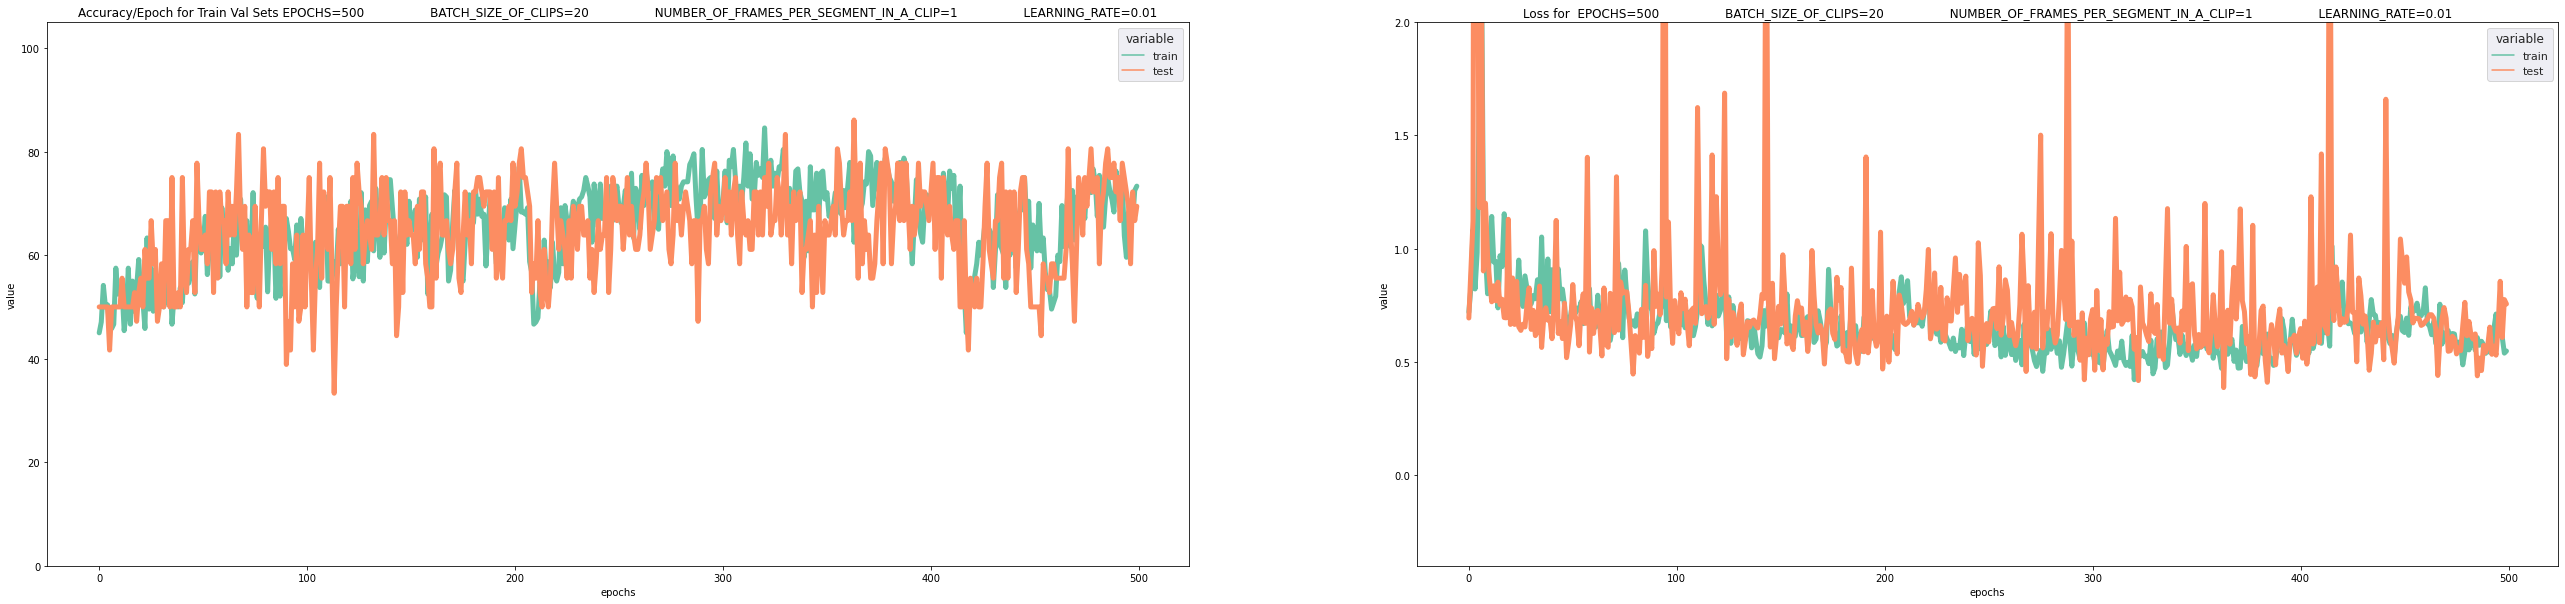

In [12]:
## Convert stats as dataframes
loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
## Concatenate dataframes and dictionaries
loss_df.insert(0, 'curve', 'Loss', True)
acc_df.insert(0, 'curve', 'Acc', True)
valuesall = [loss_df, acc_df]
values_all = pd.concat(valuesall)

all_stats = {
    'ACC': accuracy_stats,
    'LOS': loss_stats,
}


## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)


#################################
#### PLOTING
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,10))
sns.set(style="darkgrid")
sns.lineplot(
    data=acc_df, 
    x = "epochs", y="value", hue="variable",  ax=axes[0],    
    estimator=None, linewidth=5, palette="Set2" 
    ).set_title(f'Accuracy/Epoch for Train Val Sets EPOCHS={MAX_EPOCHS} \
                BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} \
                NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} \
                LEARNING_RATE={LEARNING_RATE}')

axes[0].set_ylim(0,105)

sns.set(style="darkgrid")
sns.lineplot(
    data=loss_df, 
    x = "epochs", y="value", hue="variable", ax=axes[1],
    estimator=None, linewidth=5, palette="Set2" 
    ).set_title(f'Loss for  EPOCHS={MAX_EPOCHS} \
                BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} \
                NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} \
                LEARNING_RATE={LEARNING_RATE}')
axes[1].set_ylim(-0.4, 2)



#### PREPARING AND SAVING PERFORMANCE CURVES
WIDTH = 3
PRECISION = 10
TYPE = "f"
STR_LR = f'{LEARNING_RATE:{WIDTH}.{PRECISION}{TYPE}}'
STR_LR = STR_LR.replace(".", "_", 1)

PARAMETERS_FILENAME = "TRAINset_clips_"+ \
                    str(len(train_dataset))+"TESTset_clips_"+ \
                    str(len(test_dataset))+"VALset_clips"+ \
                    str(len(val_dataset))+"___EPOCHS_"+str(f'{MAX_EPOCHS:{WIDTH}}') + \
                    "_BATCH_SIZE_OF_CLIPS_"+str(f'{BATCH_SIZE_OF_CLIPS:02}')+ \
                    "_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_"+ \
                    str(NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP)+"_LEARNING_RATE_"+ STR_LR + \
                    "_TRAINVERSION_"+TRAIN_VERSION

## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
TEMP_DICT_TRAINING_CURVES_FOR = "TEMP_DICT_TRAINING_CURVES_FOR____"
IMAGE_FILE_NAME = TEMP_DICT_TRAINING_CURVES_FOR+PARAMETERS_FILENAME
#print(IMAGE_FILE_NAME)
fig.savefig(IMAGE_FILE_NAME) 

## Saving training metrics in dictionaries at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
LOSS_ACC_DICTS_FILE_NAME = "TEMP_DICT_TRAINING_CURVES_FOR____"+"_LOSS_ACC_"+PARAMETERS_FILENAME+'.json'
#print(LOSS_ACC_DICTS_FILE_NAME)
#print(all_stats)

with open(LOSS_ACC_DICTS_FILE_NAME, 'w') as file:
   file.write(json.dumps(all_stats, indent=2))
    


## 11. Evaluate the model on test dataset

In [13]:
model.load_state_dict(torch.load(
    os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth")))
model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(val_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(DEVICE), sample_batched[1].to(DEVICE)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
print(f'==================================================')        
print(f'==================================================')        
print(get_class_distribution(val_dataset, label_id))
print(f'y_true_list{y_true_list}')
print(f'y_pred_list{y_pred_list}')



 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([20, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([20])
 BATCH_OF_CLIPS_INDEX: 1 
   X_train_batch.size(): torch.Size([20, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([20])
 BATCH_OF_CLIPS_INDEX: 2 
   X_train_batch.size(): torch.Size([4, 1, 1, 128, 128])
   y_train_batch.size(): torch.Size([4])
{'BKGR': 22, '4CV': 22}
y_true_list[0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]
y_pred_list[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]


              precision    recall  f1-score   support

           0       0.61      0.64      0.62        22
           1       0.62      0.59      0.60        22

    accuracy                           0.61        44
   macro avg       0.61      0.61      0.61        44
weighted avg       0.61      0.61      0.61        44

                    Precision    Recall  F1-score  Support
0                    0.608696  0.636364  0.622222     22.0
1                    0.619048  0.590909  0.604651     22.0
weighted avg/Total   0.613872  0.613636  0.613437      NaN
Avg/Total                 NaN       NaN       NaN     44.0
[[14  8]
 [ 9 13]]
Elapsed time for the notebook loop: 590.0780346393585 (s)


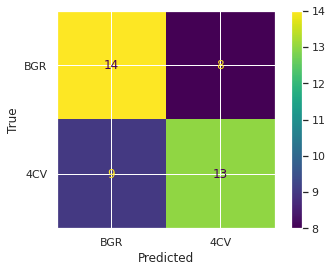

In [14]:
report = classification_report(y_true_list, y_pred_list)
print(report)
# report_support = precision_recall_fscore_support(y_true_list, y_pred_list)
# print(report_support)

def metrics_report_to_df(ytrue, ypred):
    classification_report_df = pd.DataFrame(data=list(precision_recall_fscore_support(y_true_list, y_pred_list)), \
                                         index=['Precision', 'Recall', 'F1-score', 'Support']).T    
    classification_report_df.loc['weighted avg/Total', :] = precision_recall_fscore_support(ytrue, ypred, average='weighted')
    classification_report_df.loc['Avg/Total', 'Support'] = classification_report_df['Support'].sum()
    return(classification_report_df)

classification_report_df = metrics_report_to_df(y_true_list, y_pred_list)
print(classification_report_df)

#################################
### PLOTTING CONFUSION MATRIX
cm=confusion_matrix(y_true_list, y_pred_list)
print(cm)
#cm=confusion_matrix(y_true_list, y_pred_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['BGR','4CV'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')


END_TIME_OF_THE_NOTEBOOK = time.time()
NOTEBOOK_ELAPSE_TIME = END_TIME_OF_THE_NOTEBOOK - START_TIME_OF_THE_NOTEBOOK
print(f'Elapsed time for the notebook loop: {NOTEBOOK_ELAPSE_TIME} (s)')



#### PREPARING AND SAVING TRAINING PERFORMANCE PARAMETERS
train_values = {} # instantiate an empty train_values dict 
train_values['elapsed_time_for_the_NOTEBOOK_in_secs'] = NOTEBOOK_ELAPSE_TIME
train_values['elapsed_time_for_the_training_loop_in_secs'] = elapsed_time
train_values['MAX_EPOCHS'] = MAX_EPOCHS
train_values['LEARNING_RATE'] = LEARNING_RATE
train_values['BATCH_SIZE_OF_CLIPS'] = BATCH_SIZE_OF_CLIPS
train_values['PRETRANSFORM_IM_SIZE'] = PRETRANSFORM_IM_SIZE
train_values['FRAMES_PER_CLIP'] = NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP
train_values['Train Dataset Size in Number of Frames'] = len(train_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Test Dataset Size in Number of Frames'] = len(test_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Validation Dataset Size in Number of Frames'] = len(val_dataset)*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP*BATCH_SIZE_OF_CLIPS
train_values['Current date and time'] = datetime.now().strftime('%dD-%mM-%yY_%HH-%MM-%SS')
train_values['Classification Report']=classification_report_df.head().to_dict()
train_values['Optimizer']=pd.read_csv(io.StringIO(str(optimizer))).to_dict()
train_values['Arquitecture']=(str(model)[:])#.head().to_dict()
# train_values['Arquitecture']=pd.read_csv(io.StringIO(str(model)),header=None).to_dict()
#pd.read_csv(io.StringIO(str(model)[:])).to_dict()

# 


    
#team['konqi'] = {'health': 18, 'level': 7}

## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
TRAIN_FILE_NAME = TEMP_DICT_TRAINING_CURVES_FOR+"TRAINING_PARAMETERS"+PARAMETERS_FILENAME+".json"


with open(TRAIN_FILE_NAME, 'w') as file:
     file.write(json.dumps(train_values, indent=4))

        


## 12. [**!WARNING!**] Cleanup temporal data directory 
Remove directory if a temporary was used.

```
       Make sure you know which path you will remove as you do not like to remove important files.
       shutil.rmtree
```

In [15]:
temporal_files_path = config['temporal_data_path']

shutil.rmtree(temporal_files_path)
print(f' {temporal_files_path} is empty')

 /home/mx19/datasets/vital-us/echocardiography/temporal-files/ is empty
